In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 47.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 95.0 MB/s eta 0:00:00


In [4]:
!pip3 install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 112.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 50.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fo

In [5]:
import pandas as pd
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, concatenate
from transformers import TFBertForSequenceClassification
from keras.layers import Flatten
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Conv1D, concatenate, Flatten
from tensorflow.keras.models import Model
from transformers import TFBertModel
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Reshape

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import os
import numpy as np

In [20]:
df_train = pd.read_csv(r'/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/train.csv')
df_test = pd.read_csv(r'/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/test.csv')

In [8]:
def get_graph_feature():
    graph_feature_train_data_path = "/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/train_feature.txt"

    graph_feature_test_data_path = "/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/test_feature.txt"

    graph_feature_train = np.loadtxt(graph_feature_train_data_path).tolist()  # graph feature train
    graph_feature_test = np.loadtxt(graph_feature_test_data_path).tolist()  # graph feature test

    for i in range(len(graph_feature_train)):
        graph_feature_train[i] = [graph_feature_train[i]]

    for i in range(len(graph_feature_test)):
        graph_feature_test[i] = [graph_feature_test[i]]

    return graph_feature_train, graph_feature_test

In [9]:
graph_train, graph_test = get_graph_feature()
graph_train = np.array(graph_train)
graph_test = np.array(graph_test)

In [35]:
graph_test[0]

array([[ 0.007713,  0.047599, -0.040279]])

In [23]:
df_train['opcode'] = df_train['opcode'].astype(str)
df_test['opcode'] = df_test['opcode'].astype(str)

In [28]:
from keras.utils import to_categorical
y_train = df_train['label'].values
y_train = to_categorical(y_train)
y_test = df_test['label'].values
y_test = to_categorical(y_test)

In [29]:
## Tiền xử lý opcode
VOCAB_OP_SIZE = df_train['opcode'].nunique()
MAX_OPCODE_LENGTH = 200
EMBEDDING_SIZE = 256

In [30]:
# Khởi tạo tokenizer
tokenizer = Tokenizer(num_words=VOCAB_OP_SIZE)

# Fit tokenizer với các opcode
tokenizer.fit_on_texts(df_train['opcode'])

# Chuyển đổi các opcode thành các sequence
sequences = tokenizer.texts_to_sequences(df_train['opcode'])

# Padding các sequence để có độ dài bằng nhau
opcode_matrix = pad_sequences(sequences, maxlen=MAX_OPCODE_LENGTH)

In [14]:
## Tiền xử lý source code
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [15]:
MAX_SOURCECODE_LENGTH = 200
VOCAB_SOURCE_SIZE = df_train['source_code'].nunique()

In [16]:
# BERT model for source code
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

bert_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='source_code')
preprocessed_text = bert_preprocess(bert_input)
bert_outputs = bert_encoder(preprocessed_text)

bert_output = tf.keras.layers.Dropout(0.3, name="dropout_layer")(bert_outputs['pooled_output'])
bert_output = tf.keras.layers.Dense(32, name="bert_output")(bert_output)

In [17]:
# Model Bi-LSTM
lstm_input = Input(shape=(MAX_OPCODE_LENGTH,), dtype='int32', name='lstm_input')
lstm_layer1 = Embedding(input_dim=VOCAB_OP_SIZE, output_dim=EMBEDDING_SIZE, input_length=MAX_OPCODE_LENGTH)(lstm_input)
lstm_layer2 = Bidirectional(LSTM(units=128, return_sequences=True))(lstm_layer1)
lstm_layer3 = Dropout(0.3)(lstm_layer2)
lstm_layer4 = Bidirectional(LSTM(units=128))(lstm_layer3)
lstm_output = Dense(units=32, activation='relu')(lstm_layer4)

In [18]:
gnn_input = tf.keras.Input(shape=(1,3), name='gnn_input')
# gnn_layer1 = tf.keras.layers.Conv1D(200, kernel_size=3, strides=1, activation=tf.nn.relu, padding='same')(gnn_input)
# gnn_layer2 = tf.keras.layers.MaxPooling1D(pool_size=1, strides=1)(gnn_layer1)
gnn_output = tf.keras.layers.Dense(32, activation='relu')(gnn_input)
gnn_output_flattened = tf.keras.layers.Flatten()(gnn_output)  # Flatten gnn_output
# gnn_layer1 = tf.keras.layers.Conv1D(200, kernel_size=3, strides=1, activation=tf.nn.relu)(gnn_input)
# gnn_output = tf.keras.layers.MaxPooling1D(pool_size=1, strides=1)(gnn_layer1)

In [19]:
# # Model Multimodal
# dense_out_bert = Dense(64, activation='relu')(bert_output)
# dense_out_lstm = Dense(64, activation='relu')(lstm_output)
concatenated = concatenate([bert_output, lstm_output, gnn_output_flattened], axis=-1)
concatenated_reshaped = Reshape((96, 1))(concatenated)
conv_out = Conv1D(64, 3, activation='relu')(concatenated_reshaped)
flatten_out = Flatten()(conv_out)
dense_out = Dense(32, activation='relu')(flatten_out)
dense_out = Dropout(0.3)(dense_out)
final_out = Dense(3, activation='softmax')(dense_out)

In [20]:
from tensorflow.keras import optimizers
model = Model(inputs=[bert_input, lstm_input, gnn_input], outputs=final_out)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_input (InputLayer)     [(None, 200)]                0         []                            
                                                                                                  
 source_code (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 256)             361216    ['lstm_input[0][0]']          
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['source_code[0][0]']         
                             128),                                                            

In [21]:
model.fit([df_train['source_code'], opcode_matrix, graph_train], y_train, epochs=30, batch_size=32)

Epoch 1/30
45/45 [==============================] - 46s 449ms/step - loss: 0.5552 - accuracy: 0.7176 - precision: 0.6436 - recall: 0.3420
Epoch 2/30
45/45 [==============================] - 19s 413ms/step - loss: 0.4147 - accuracy: 0.8160 - precision: 0.7461 - recall: 0.6792
Epoch 3/30
45/45 [==============================] - 18s 407ms/step - loss: 0.3777 - accuracy: 0.8226 - precision: 0.7578 - recall: 0.6876
Epoch 4/30
45/45 [==============================] - 18s 411ms/step - loss: 0.3727 - accuracy: 0.8344 - precision: 0.7738 - recall: 0.7110
Epoch 5/30
45/45 [==============================] - 19s 412ms/step - loss: 0.3664 - accuracy: 0.8400 - precision: 0.7796 - recall: 0.7251
Epoch 6/30
45/45 [==============================] - 19s 416ms/step - loss: 0.3460 - accuracy: 0.8445 - precision: 0.7947 - recall: 0.7194
Epoch 7/30
45/45 [==============================] - 19s 423ms/step - loss: 0.3326 - accuracy: 0.8580 - precision: 0.8085 - recall: 0.7519
Epoch 8/30
45/45 [================

In [22]:
sequences_opcode_test = tokenizer.texts_to_sequences(df_test['opcode'])
opcode_matrix_test = pad_sequences(sequences_opcode_test, maxlen=MAX_OPCODE_LENGTH)

In [23]:
y_pred = model.predict([df_test['source_code'], opcode_matrix_test, graph_test], batch_size=32)

12/12 [==============================] - 6s 391ms/step


In [24]:
y_pred

array([[3.3141553e-10, 1.0000000e+00, 1.6727244e-08],
       [1.0199395e-18, 1.2558124e-16, 1.0000000e+00],
       [6.6152148e-18, 6.2696675e-16, 1.0000000e+00],
       ...,
       [8.9895821e-01, 9.9227250e-02, 1.8145317e-03],
       [9.9999213e-01, 7.6967171e-06, 1.2574573e-07],
       [2.4031992e-01, 7.5942564e-01, 2.5438602e-04]], dtype=float32)

In [25]:
import numpy as np
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.7388    0.7333    0.7361       135
           1     0.6486    0.6990    0.6729       103
           2     0.8899    0.8362    0.8622       116

    accuracy                         0.7571       354
   macro avg     0.7591    0.7562    0.7571       354
weighted avg     0.7621    0.7571    0.7590       354



In [26]:
from sklearn.metrics import accuracy_score
print("Accuracy MultiClass: ", accuracy_score(y_test_classes, y_pred_classes))

Accuracy MultiClass:  0.7570621468926554


In [27]:
model.save('/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Model/VulnSense')

In [27]:
model.save('saved_model/bert_mutil_data')
acc = []
pre = []
rec = []
f1 = []
for i in range(11, 31):
  print(i)
  model = tf.keras.models.load_model('saved_model/bert_mutil_data')
  model.fit([df_train['source_code'], opcode_matrix, graph_train], y_train, epochs=1, batch_size=32)
  y_predicted = model.predict([df_test['source_code'], opcode_matrix_test, graph_test], batch_size=32)
  y_predicted_1 = np.argmax(y_predicted, axis=1)
  y_test_1 = np.argmax(y_test, axis=1)
  metric = [i for i in classification_report(y_test_1, y_predicted_1, digits=4).split('\n')[-2].split(' ')[2:-1] if i != '']
  acc.append(round(accuracy_score(y_test_1, y_predicted_1), 4))
  pre.append(metric[0])
  rec.append(metric[1])
  f1.append(metric[2])
  model.save('saved_model/bert_mutil_data')

11
12/12 [==============================] - 6s 388ms/step
12
12/12 [==============================] - 6s 390ms/step
13
12/12 [==============================] - 6s 394ms/step
14
12/12 [==============================] - 6s 391ms/step
15
12/12 [==============================] - 6s 392ms/step
16
12/12 [==============================] - 11s 389ms/step
17
12/12 [==============================] - 6s 390ms/step
18
12/12 [==============================] - 6s 347ms/step
19
12/12 [==============================] - 6s 368ms/step
20
12/12 [==============================] - 7s 365ms/step
21
12/12 [==============================] - 6s 366ms/step
22
12/12 [==============================] - 6s 366ms/step
23
12/12 [==============================] - 6s 371ms/step
24
12/12 [==============================] - 6s 372ms/step
25
12/12 [==============================] - 6s 367ms/step
26
12/12 [==============================] - 6s 367ms/step
27
12/12 [==============================] - 6s 373ms/step
28
12/12 [===

In [28]:
for i in acc:
  print(i)

0.7542
0.7655
0.7571
0.7627
0.7627
0.7655
0.774
0.7797
0.774
0.7571
0.774
0.7797
0.7825
0.791
0.7684
0.7684
0.7881
0.7938
0.7797
0.7881


In [29]:
for i in pre:
  print(i)

0.7917
0.7842
0.7677
0.7836
0.7776
0.7649
0.7841
0.7896
0.7777
0.7603
0.7724
0.7811
0.7850
0.8034
0.7815
0.7679
0.7897
0.8009
0.7792
0.7883


In [30]:
for i in rec:
  print(i)

0.7542
0.7655
0.7571
0.7627
0.7627
0.7655
0.7740
0.7797
0.7740
0.7571
0.7740
0.7797
0.7825
0.7910
0.7684
0.7684
0.7881
0.7938
0.7797
0.7881


In [31]:
for i in f1:
  print(i)

0.7542
0.7660
0.7603
0.7642
0.7645
0.7647
0.7715
0.7786
0.7735
0.7573
0.7725
0.7787
0.7795
0.7907
0.7638
0.7668
0.7831
0.7952
0.7767
0.7842


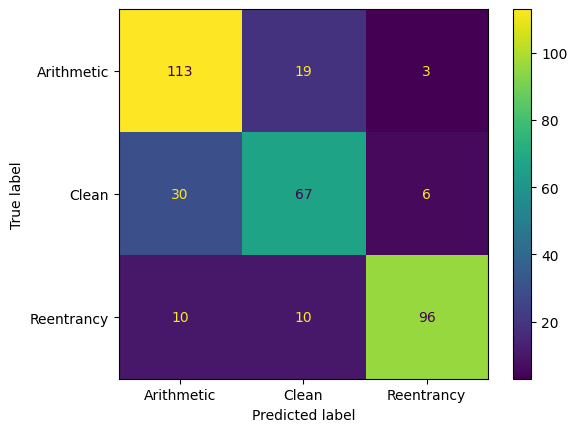

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.show()

In [ ]:
model.save('Multimodal/Multimodal_data2')

# Epochs 20

In [ ]:
model1 = tf.keras.models.load_model('Multimodal/Multimodal_data2')

In [ ]:
model1.fit([df_train['source_code'], opcode_matrix, graph_train], y_train, epochs=10, batch_size=32)

Epoch 1/10
45/45 [==============================] - 29s 223ms/step - loss: 0.3493 - accuracy: 0.8561 - precision: 0.8141 - recall: 0.7364
Epoch 2/10
45/45 [==============================] - 9s 192ms/step - loss: 0.3206 - accuracy: 0.8629 - precision: 0.8182 - recall: 0.7569
Epoch 3/10
45/45 [==============================] - 9s 191ms/step - loss: 0.3117 - accuracy: 0.8627 - precision: 0.8137 - recall: 0.7625
Epoch 4/10
45/45 [==============================] - 9s 193ms/step - loss: 0.3022 - accuracy: 0.8700 - precision: 0.8337 - recall: 0.7618
Epoch 5/10
45/45 [==============================] - 9s 189ms/step - loss: 0.2920 - accuracy: 0.8690 - precision: 0.8291 - recall: 0.7647
Epoch 6/10
45/45 [==============================] - 9s 192ms/step - loss: 0.2959 - accuracy: 0.8744 - precision: 0.8356 - recall: 0.7760
Epoch 7/10
45/45 [==============================] - 9s 192ms/step - loss: 0.2870 - accuracy: 0.8784 - precision: 0.8450 - recall: 0.7781
Epoch 8/10
45/45 [======================

In [ ]:
model1.evaluate([df_test['source_code'], opcode_matrix_test, graph_test], y_test, verbose=1, batch_size=32)

12/12 [==============================] - 4s 162ms/step - loss: 0.3279 - accuracy: 0.8512 - precision: 0.7917 - recall: 0.7514


[0.32789430022239685,
 0.8512241244316101,
 0.7916666865348816,
 0.7514124512672424]

In [ ]:
y_pred = model1.predict([df_test['source_code'], opcode_matrix_test, graph_test], batch_size=32)

12/12 [==============================] - 4s 154ms/step


In [ ]:
import numpy as np
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.6864    0.8593    0.7632       135
           1     0.7250    0.5631    0.6339       103
           2     0.9143    0.8276    0.8688       116

    accuracy                         0.7627       354
   macro avg     0.7752    0.7500    0.7553       354
weighted avg     0.7723    0.7627    0.7602       354



In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test_classes, y_pred_classes))

0.7627118644067796


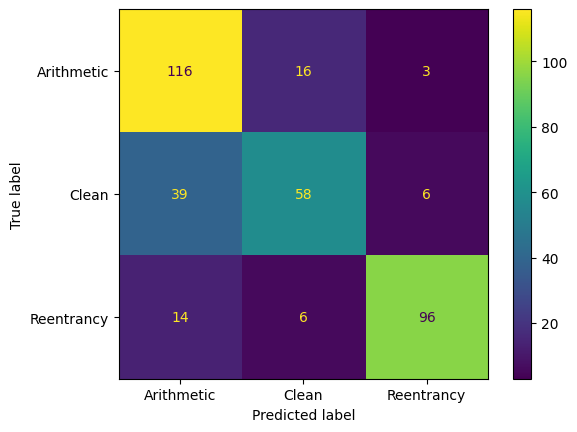

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.show()

In [ ]:
model1.save('Multimodal/Multimodal_data2')

# Epochs 30

In [ ]:
model2 = tf.keras.models.load_model('Multimodal/Multimodal_data2')

In [ ]:
model2.fit([df_train['source_code'], opcode_matrix, graph_train], y_train, epochs=10, batch_size=32)

Epoch 1/10
45/45 [==============================] - 28s 219ms/step - loss: 0.2564 - accuracy: 0.8860 - precision: 0.8487 - recall: 0.8007
Epoch 2/10
45/45 [==============================] - 9s 196ms/step - loss: 0.2401 - accuracy: 0.8966 - precision: 0.8714 - recall: 0.8092
Epoch 3/10
45/45 [==============================] - 8s 186ms/step - loss: 0.2259 - accuracy: 0.9027 - precision: 0.8773 - recall: 0.8233
Epoch 4/10
45/45 [==============================] - 9s 194ms/step - loss: 0.2125 - accuracy: 0.9131 - precision: 0.8926 - recall: 0.8403
Epoch 5/10
45/45 [==============================] - 9s 196ms/step - loss: 0.2054 - accuracy: 0.9117 - precision: 0.8904 - recall: 0.8382
Epoch 6/10
45/45 [==============================] - 9s 191ms/step - loss: 0.1911 - accuracy: 0.9143 - precision: 0.8919 - recall: 0.8452
Epoch 7/10
45/45 [==============================] - 9s 193ms/step - loss: 0.1892 - accuracy: 0.9201 - precision: 0.9027 - recall: 0.8523
Epoch 8/10
45/45 [======================

In [ ]:
y_test2 = df_test['label'].values
y_test2 = to_categorical(y_test2)

In [ ]:
model2.evaluate([df_test['source_code'], opcode_matrix_test, graph_test], y_test, verbose=1, batch_size=32)

12/12 [==============================] - 4s 160ms/step - loss: 0.4683 - accuracy: 0.8531 - precision: 0.7878 - recall: 0.7655


[0.46828189492225647,
 0.8531073331832886,
 0.7877907156944275,
 0.7655367255210876]

In [ ]:
import numpy as np
y_predicted2 = model2.predict([df_test['source_code'], opcode_matrix_test, graph_test], batch_size=32)
y_predicted2 = np.argmax(y_predicted2, axis=1)
y_test2 = np.argmax(y_test2, axis=1)

12/12 [==============================] - 4s 159ms/step


In [ ]:
print(classification_report(y_test2, y_predicted2))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79       135
           1       0.71      0.64      0.67       103
           2       0.90      0.84      0.87       116

    accuracy                           0.79       354
   macro avg       0.79      0.78      0.78       354
weighted avg       0.79      0.79      0.78       354



In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test_classes, y_pred_classes))

0.7627118644067796


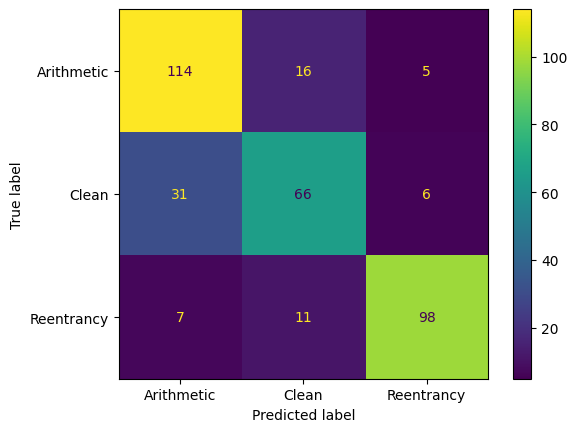

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test2, y_predicted2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.savefig("/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Figure/KLTN/Multimodal1_30.png", dpi=1200, transparent=True)
plt.show()